# 4.1: Depth-first search
* Finds all vertices of a graph that can be reached from the start
* Paths represented by search tree
* Not guarenteed to be the shortest path

Dist b/t nodes is the length of the shortest path

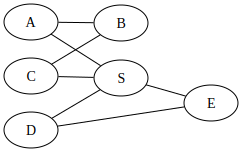

In [1]:
from graphviz import Graph

graph = Graph(graph_attr={"rankdir":"LR"})

nodes = set("EDSCAB")
adj = {
    "E": set(("D", "S")),
    "D": set(("E", "S")),
    "S": set(("E", "D", "C", "A")),
    "C": set(("S", "B")),
    "A": set(("S", "B")),
    "B": set(("C", "A"))
}

edges = {frozenset((u,v)) for u,neighbors in adj.items() for v in neighbors}

for node in nodes:
    graph.node(node, node)

for u,v in edges:
    graph.edge(u,v)

graph

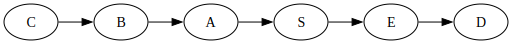

In [2]:
from graphviz import Digraph

def dfs(start, adj):
    dfs_tree = {}
    to_visit = [(None, start)]

    while to_visit:
        u,v = to_visit.pop()
        if v not in dfs_tree:
            dfs_tree[v] = u
            for neighbor in adj[v]:
                to_visit.append((v, neighbor))

    return dfs_tree

dfs_tree = dfs("C", adj)

def tree_to_graph(tree):
    graph = Digraph(graph_attr={"rankdir": "LR"})
    for v,u in tree.items():
        if u is not None:
            graph.node(u)
            graph.edge(u,v)
    return graph

tree_to_graph(dfs_tree)

# 4.2: Breadth-first search
* Uses queue (FIFO) insead of stack (LIFO) for DFS
* Visits all neighbors (dist 1), then neighbors of neighbors (dist 2)...
* BFS tree is a shortest path tree, guarenteed to be shortest path

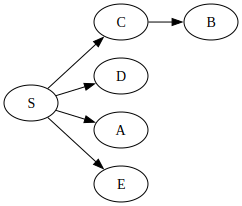

In [3]:
from queue import Queue

def bfs(start, adj):
    bfs_tree = {}
    to_visit = Queue()
    to_visit.put((None, start))

    while not to_visit.empty():
        u,v = to_visit.get()
        if v not in bfs_tree:
            bfs_tree[v] = u
            for neighbor in adj[v]:
                to_visit.put((v, neighbor))

    return bfs_tree

bfs_tree = bfs("S", adj)

tree_to_graph(bfs_tree)

In [4]:
def bfs_dists(start, adj):
    dists = {start: 0}

    to_visit = Queue()
    to_visit.put(start)

    while not to_visit.empty():
        v = to_visit.get()
        for neighbor in adj[v]:
            if neighbor not in dists:
                dists[neighbor] = dists[v] + 1
                to_visit.put(neighbor)

    return dists

dists = bfs_dists("S", adj)
print(dists)

{'S': 0, 'C': 1, 'D': 1, 'A': 1, 'E': 1, 'B': 2}


## BFS proof
Show for each $d = 0, 1, 2...$, there must be a moment where:
1. All nodes w/ dist $\le d$ from $s$ have their dists set correctly
2. All node w/ dist $> d$ have dist $= \infty$
3. Queue $Q$ contains exactly nodes at dist $d$

#### Proof by induction:
Base case: at $d = 0$
1. Node $s$ has dist $d = 0$
2. All other nodes have dist $= \infty$
3. Queue $Q$ contains only $s$, the only node at dist $d = 0$

Inductive hypothesis:
* Assume that for $d = k$
    1. All nodes w/ $d \le k$ have their dists set correctly
    2. All nodes w/ dist $> k$ have dist $= \infty$
    3. Queue $Q$ contains exactly nodes at dist $k$
* Show the 3 conditions for $d = k+1$

Inductive step:  
Following the BFS algorithm, for each node in $Q$ (only contains nodes at dist $k$): remove the node from $Q$, and for each neighboring node, check if the distance is $\infty$. The distance will only be $\infty$ if it has a dist $d > k$, since dists of all nodes w/ $d \le k$ are already set correctly. If the distance if $\infty$, then we know that we have not yet seen that node yet, and its distance will be set to $k+1$ and it will be added to the queue.  
After processing all nodes of distance $d$:
1. All nodes w/ $d \le k+1$ have their dists set correctly since we set newly discovered node dists to $k+1$ and previously all nodes w/ $d \le k$ had dists set correctly.
2. All nodes w/ dist $> k+1$ have dist $= \infty$ since we have only set nodes of dist $k+1$.
3. Queue $Q$ contains exactly nodes at dist $k+1$ since we removed all nodes of dist $k$ and added all nodes of dist $k+1$

$QED$

Runtime is $O(|V|+E)$, same as DFS. Each visitable vertex is visited once, and each edge touching the vertex is taken.

DFS goes deep into the graph, backtracking when there are no more new nodes to visit.

BFS visits nodes in order of their distance to the starting point. Wave propagating from the starting node.

# 4.4: Dijkstra's algorithm (Lengths on edges)
BFS doesn't consider lengths: edge lengths $l_e = 1$  
We want a generalization of BFS w/ edge lengths $l_e \in \mathbb{Z}^+$

## Naive approach
BFS is a wave propagating out from the initial node. To consider lengths, cut each edge length into unit length pieces and add dummy nodes.

For each edge $(u,v)$ in $E$, replace it with $l_e$ edges of length $1$, adding $l_e - 1$ dummy nodes b/t $u,v$.

This is bad because we spend most time moving between dummy nodes.

## Dijkstra's algorithm
Instead, use an "alarm clock", setting it to the time of estimated arrival of neighboring nodes, and sleep until you are woken up. 

$l(s,u) = T$. For each neighbor $v$ of $u$ in $G$: if there is no alarm for $v$, set one for $T+l(u,v)$; if $v$ has an alarm later than $T+l(u,v)$, then set the alarm to $T+l(u,v)$.

Alarm system is implemented by priority queue (min heap). Visit the closest node at each iteration.

Add neighbors to priority queue based on length from initial node. When we pop from the priority queue, we know we are getting the closest next node. If the node doesn't already have a set distance, then set it and add all of its neighbors to the PQ.

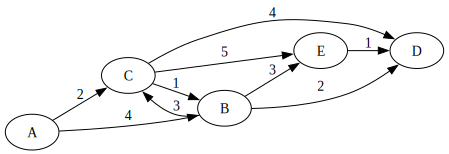

In [5]:
nodes = set("ABCDE")
edges = {
    tuple("AB"): 4,
    tuple("AC"): 2,
    tuple("BC"): 3,
    tuple("BD"): 2,
    tuple("BE"): 3,
    tuple("CB"): 1,
    tuple("CE"): 5,
    tuple("CD"): 4,
    tuple("ED"): 1,
}

adj = {n:set() for n in nodes}
for u,v in edges:
    adj[u].add(v)

graph = Digraph(graph_attr={"rankdir": "LR"})
for node in nodes:
    graph.node(node, node)

for (u,v), l in edges.items():
    graph.edge(u,v,str(l))

graph

{'A': 0, 'C': 2, 'B': 3, 'D': 5, 'E': 6}
{'A': None, 'C': 'A', 'B': 'C', 'D': 'B', 'E': 'B'}


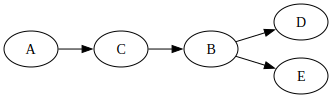

In [6]:
from heapq import heappop, heappush

dists = {}
prevs = {}

to_visit = [(0, "A", None)]

while to_visit:
    dist, u, prev = heappop(to_visit)
    if u not in dists:
        dists[u] = dist
        prevs[u] = prev
        for v in adj[u]:
            heappush(to_visit, (dist + edges[(u,v)], v, u))

print(dists)
print(prevs)

tree_to_graph(prevs)

Using binary min-heap priority queue gives $O((|V|+|E|)log|V|)$ running time: $O(|V|+|E|)$ heap pushes and pops, each costing $O(\log |V|)$ for a binary heap.

Running time of Dijkstra depends on priority queue implementation.
* Array, binary heap, d-ary heap, fibonacci heap

# 4.5: Priority queue implementations
## Array
Unordered array of $(k,v)$.

Insert: append, $O(1)$
Pop: linear scan to find min $O(n)$

## Binary heap
Complete binary heap (array underneath). Min heap, smallest is always index 0 (root).

Insert: append to array and bubble up. $O(\log n)$  
Pop: swap root with last, pop new last, and bubble down new root. $O(\log n)$

Parent: $(i - 1) // 2$  
Children: $2i + 1, 2i+2$

## $d$-ary heap
Binary heap except nodes have $d$ children instead of 2.  
Tree height $O(\log_d n) = \Theta(\frac{\log n}{\log d})$.

Insert: faster by factor of $\Theta(\log d)$  
Pop: $O(d \log_d n)$, since when bubbling down, we have to search through $d$ nodes at each level.

Array underneath just like binary heap.
* Parent: $(i - 1) // d$  
* Children: $\{ i * d + j : j \in [1,d] \}$

## Comparing PQs
| Implementation | pop                            | insert                       | $V * \text{pop} + (V+E) * \text{insert}$  |
| ---------------|--------------------------------|------------------------------|-------------------------------------------|
| Array          | $O(V)$                         | $O(1)$                       | $O(|V|^2)$                                |
| Binary heap    | $O(\log V)$                    | $O(\log V)$                  | $O((V+E) \log V)$                         |
| $d$-ary heap   | $O(\frac{d \log V}{\log d})$   | $O(\frac{\log V}{\log d})$   | $O((dV+E) \frac{\log V}{\log d}$          |
| Fibonacci heap | $O(logV)$                      | $O(1)$ amortized             | $O(V \log V + E)$                         |

$|E| < |V^2|$ always.

Array is better than binary heap when graph is very dense $E = \Theta (|V|^2)$. Binary heap is better when $E < \frac{|V|^2}{\log |V|}$.

Optimal $d \approx \frac{|E|}{|V|}$, or the average degree of nodes.

# 4.6: Shortest path with negative edges

## Negative edges
Dijkstra's algorithm only works for positive edges, assumes that the shortest path from $s$ to $v$ only passes through nodes closer than $v$. If edge lengths can be negative, we may pass through nodes further away, and then use negative edges to get even shorter paths.

$\text{dist}$ values must always be overestimates or correct. Values start at $\infty$ and are updated when moving to that node.  

$\text{update}: \text{dist}(v) = \min \{ \text{dist}(v), \text{dist}(u) + l(u,v) \}$  
1. Gives correct dist to $v$ when $u$ is the second-to-last node in the shortest path from $s$ to $v$ and $\text{dist}(u)$ is correct.
2. Will never make $\text{dist}(v)$ too small

Shortest path: $s \to u_1 \to u_2 ... \to u_k \to t$  
At most $|V|$ - 1 edges, when $t$ is the farthest it can be to $s$.

If the sequence of updates is $(s,u_1), (u_1, u_2),..., (u_k, t)$, then by property 1, $\text{dist}(t)$ will be correct.

We don't know that the the shortest path, so we won't be able to update the edges in the correct order.

Bellman-Ford algorithm: update all edges $|V| - 1$ times. In the worst case (when the best path for $t$ is $|V| - 1$ edges), all preceding nodes will have correct values since they require $< |V| - 1$ edges, so then $\text{dist}(t)$ will be updated correctly. $O(|V||E|)$ since we call $\text{update}$ on every edge $|V|-1$ times.

Most edges aren't perfectly linear, so will need less than $|V| - 1$ iterations. If no dists were updated, then terminate.

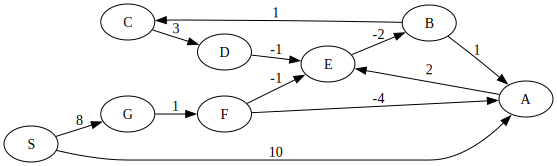

In [7]:
nodes = set("SABCDEFG")
edges = {
    tuple("SA"): 10,
    tuple("BA"): 1,
    tuple("BC"): 1,
    tuple("CD"): 3,
    tuple("DE"): -1,
    tuple("FE"): -1,
    tuple("GF"): 1,
    tuple("SG"): 8,
    tuple("FA"): -4,
    tuple("AE"): 2,
    tuple("EB"): -2,
}

adj = {n:set() for n in nodes}
for u,v in edges:
    adj[u].add(v)

graph = Digraph(graph_attr={"rankdir": "LR"})
for node in nodes:
    graph.node(node, node)

for (u,v), l in edges.items():
    graph.edge(u,v,str(l))

graph

In [8]:
def update(dists, edge):
    """Returns True if dists was updated."""
    u, v = edge
    min_dist = min(dists[v], dists[u] + edges[edge])

    if min_dist == dists[v]:
        return False
    else:
        dists[v] = min_dist
        return True

dists = {n:float("inf") for n in nodes}
dists["S"] = 0

print(dists)

for _ in range(len(nodes) - 1):
    updated = False
    for edge in edges:
        updated = update(dists, edge) or updated

    if not updated:
        break
    
    print(dists)

{'C': inf, 'D': inf, 'E': inf, 'B': inf, 'G': inf, 'A': inf, 'S': 0, 'F': inf}
{'C': inf, 'D': inf, 'E': 12, 'B': 10, 'G': 8, 'A': 10, 'S': 0, 'F': inf}
{'C': 11, 'D': 14, 'E': 7, 'B': 5, 'G': 8, 'A': 5, 'S': 0, 'F': 9}
{'C': 6, 'D': 9, 'E': 7, 'B': 5, 'G': 8, 'A': 5, 'S': 0, 'F': 9}


## Negative cycles
Negative cycles are when taking a cycle gives a net negative path length. Repeating the cycle will give $-\infty$ path lengths.

There is no "shortest path" if there is a negative cycle.

Every time we run update, the minimum dist will keep getting lower. If there are no negative cycles, then after $|V-1|$ iterations, on the $|V|$ th iteration no values will change. If there is a negative cycle, then some values will decrease.

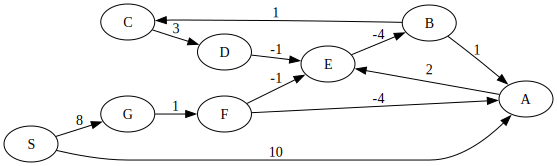

In [9]:
nodes = set("SABCDEFG")
edges = {
    tuple("SA"): 10,
    tuple("BA"): 1,
    tuple("BC"): 1,
    tuple("CD"): 3,
    tuple("DE"): -1,
    tuple("FE"): -1,
    tuple("GF"): 1,
    tuple("SG"): 8,
    tuple("FA"): -4,
    tuple("AE"): 2,
    tuple("EB"): -4,
}

adj = {n:set() for n in nodes}
for u,v in edges:
    adj[u].add(v)

graph = Digraph(graph_attr={"rankdir": "LR"})
for node in nodes:
    graph.node(node, node)

for (u,v), l in edges.items():
    graph.edge(u,v,str(l))

graph

In [10]:
def update(dists, edge):
    """Returns True if dists was updated."""
    u, v = edge
    min_dist = min(dists[v], dists[u] + edges[edge])

    if min_dist == dists[v]:
        return False
    else:
        dists[v] = min_dist
        return True

dists = {n:float("inf") for n in nodes}
dists["S"] = 0

print(dists)

for _ in range(len(nodes)):
    updated = False
    for edge in edges:
        updated = update(dists, edge) or updated

    if not updated:
        break
    
    print(dists)

# After |V| iterations, the distances are still changing, even though the most edges
# between the start and the farthest node is at most |V|-1. There must be a negative cycle.
if updated:
    print("Negative cycle detected!")

{'C': inf, 'D': inf, 'E': inf, 'B': inf, 'G': inf, 'A': inf, 'S': 0, 'F': inf}
{'C': inf, 'D': inf, 'E': 12, 'B': 8, 'G': 8, 'A': 10, 'S': 0, 'F': inf}
{'C': 9, 'D': 12, 'E': 7, 'B': 3, 'G': 8, 'A': 5, 'S': 0, 'F': 9}
{'C': 4, 'D': 7, 'E': 6, 'B': 2, 'G': 8, 'A': 4, 'S': 0, 'F': 9}
{'C': 3, 'D': 6, 'E': 5, 'B': 1, 'G': 8, 'A': 3, 'S': 0, 'F': 9}
{'C': 2, 'D': 5, 'E': 4, 'B': 0, 'G': 8, 'A': 2, 'S': 0, 'F': 9}
{'C': 1, 'D': 4, 'E': 3, 'B': -1, 'G': 8, 'A': 1, 'S': 0, 'F': 9}
{'C': 0, 'D': 3, 'E': 2, 'B': -2, 'G': 8, 'A': 0, 'S': 0, 'F': 9}
{'C': -1, 'D': 2, 'E': 1, 'B': -3, 'G': 8, 'A': -1, 'S': 0, 'F': 9}
Negative cycle detected!


# 4.7: Shortest path in DAGs
Pathfinding in DAGs is more efficient since DAGs can be linearized (topologically sorted) using DFS, then visited and updated in order.

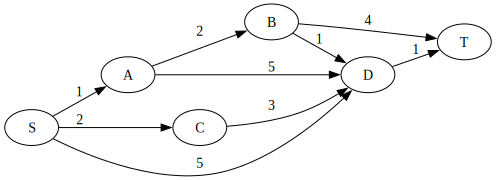

In [11]:
graph = Digraph(graph_attr={"rankdir":"LR"})

nodes = list("SACBDT")
edges = {
    ("S","A"): 1,
    ("S","C"): 2,
    ("S","D"): 5,
    ("A","B"): 2,
    ("A","D"): 5,
    ("C","D"): 3,
    ("B","D"): 1,
    ("B","T"): 4,
    ("D","T"): 1
}

adj = {node:set() for node in nodes}
adj_inv = {node:set() for node in nodes}
for u,v in edges:
    adj[u].add(v)
    adj_inv[v].add(u)

for node in nodes:
    graph.node(node, node)

for (u,v), cost in edges.items():
    graph.edge(u,v,str(cost))

graph

In [12]:
def topo_sort(u, adj, topo, visited=None):
    """Topo sort by adding all children first, then self."""
    if visited is None: visited = set()

    if u in visited:
        return
    visited.add(u)

    for v in adj[u]:
        topo_sort(v, adj, topo, visited)
    
    topo.append(u)

topo = []
topo_sort("S", adj, topo)
topo.reverse()
topo

['S', 'A', 'B', 'C', 'D', 'T']

In [13]:
def update(dists, edge):
    u, v = edge
    dists[v] = min(dists[v], dists[u] + edges[edge])

dists = {n:float("inf") for n in nodes}
dists["S"] = 0

for v in topo:
    for u in adj_inv[v]:
        update(dists, (u,v))

dists

{'S': 0, 'A': 1, 'C': 2, 'B': 3, 'D': 4, 'T': 5}